## ANALISIS DE ENERGÍA DIARIA A PARTIR DE LOS DATOS DE SOLCAST Y FRONIUS 

In [105]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Lectura DB inversor Fronius 

In [106]:
#  Cargar los datos del archivo CSV
df_SFV = pd.read_csv('../Data/Cleaned/SFV_2023.csv', sep=',')


## Lectura DB Solcast 

In [107]:
# Cargar los datos del archivo CSV
df_solcast = pd.read_csv('../Data/Cleaned/solcast_2023.csv', sep=',')
print(df_solcast.shape)



(105408, 12)


## Método para filtrar datos de un solo día 

In [108]:
# filtrar un dia de datos 
Fecha = '2023-01-12'
row_day_solcast = df_solcast.loc[df_solcast['Date'] == Fecha]
row_day_fronius = df_SFV.loc[df_SFV['Date'] == Fecha]
print(row_day_solcast.shape)
print(row_day_fronius.shape)

(287, 12)
(288, 26)


In [109]:
# reiniciar el index
row_day_solcast = row_day_solcast.reset_index(drop=True)
row_day_fronius = row_day_fronius.reset_index(drop=True)

In [110]:
# Odenernar row_day_solcast de menor a mayor hora
row_day_solcast = row_day_solcast.sort_values(by='Time')
row_day_solcast = row_day_solcast.reset_index(drop=True)

In [111]:
# Crear un nuevo dataframe con los datos de solcast y fronius a partir del indice 
df = pd.DataFrame()
df['Time'] = row_day_solcast['Time']
df['GHI'] = row_day_solcast['GHI']
df['air_temp'] = row_day_solcast['air_temp']
df['cloud_opacity'] = row_day_solcast['cloud_opacity']
df['Producción_fotovoltaica_SFV'] = row_day_fronius['Producción_fotovoltaica_SFV']
#row_day_solcast['clearsky_ghi']
df['clearsky_ghi'] = row_day_solcast['clearsky_ghi']


## Análisis producción de energía 


In [112]:
# alpha y beta 
alpha = 0.1865910334
beta = 0


#Parametros SFV
efficiency = 0.2094  # Eficiencia del panel solar
catidad_pv= 30
area =2.274*1.134

# normalizar 'cloud_opacity' de 0 a 1  en donde 1 es el valor más alto
df['cloud_opacity'] = df['cloud_opacity'] / df['cloud_opacity'].max()
# normalizar 'air_temp' de 0 a 1  en donde 1 es el valor más alto
df['air_temp'] = df['air_temp'] / df['air_temp'].max()


# Energía calculada a partir de Solcast 
df['P_cloud_opacity_temp'] = df['GHI'] * efficiency *  area * catidad_pv * (1 - beta*df['cloud_opacity']) * (1 - alpha*df['air_temp'])


# suma de la potencia generada solcast
energia = df['P_cloud_opacity_temp']*(5/60)
print("Energía calculada solacast [kWh] =",energia.sum()/1000)



# Energía calculada a partir de Fronius
df['Potencia'] = df['Producción_fotovoltaica_SFV'] / (5/60)
energia_fronius = df['Producción_fotovoltaica_SFV'].sum()
print("Producción fotovoltaica SVF [kWh/día] =",energia_fronius/1000)

# error porcentual
error = abs(  energia.sum() - energia_fronius.sum()) / energia_fronius.sum() * 100
print('Error porcentual:', error, '%')

# Horas de brillo solar
hbs = energia_fronius / (30*0.54)
print("Horas de brillo solar =", hbs/1000)

Energía calculada solacast [kWh] = 61.80248628403264
Producción fotovoltaica SVF [kWh/día] = 61.08811
Error porcentual: 1.1694195221175414 %
Horas de brillo solar = 3.7708709876543205


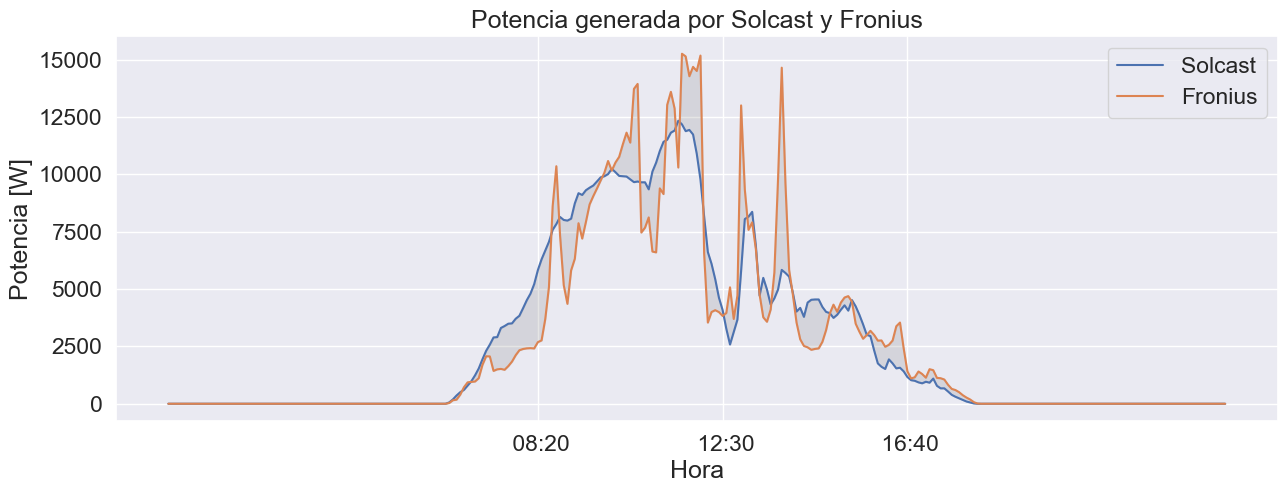

In [113]:
# graficar la energía generada por solcast y fronius
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['P_cloud_opacity_temp'], label='Solcast')
plt.plot(df['Time'], df['Potencia'], label='Fronius')
# grafico area bajo la curva
plt.fill_between(df['Time'], df['P_cloud_opacity_temp'], df['Potencia'], color='gray', alpha=0.2)
plt.title('Potencia generada por Solcast y Fronius')
plt.xlabel('Hora')
plt.ylabel('Potencia [W]')
plt.legend()
plt.xticks([100, 150, 200])
plt.show()

## Análisis con el cielo despejado

In [114]:
P_clearsky_ghi = df['clearsky_ghi'] * efficiency *  area * catidad_pv
# print(P_clearsky_ghi)
P_ghi = df['GHI'] * efficiency *  area * catidad_pv

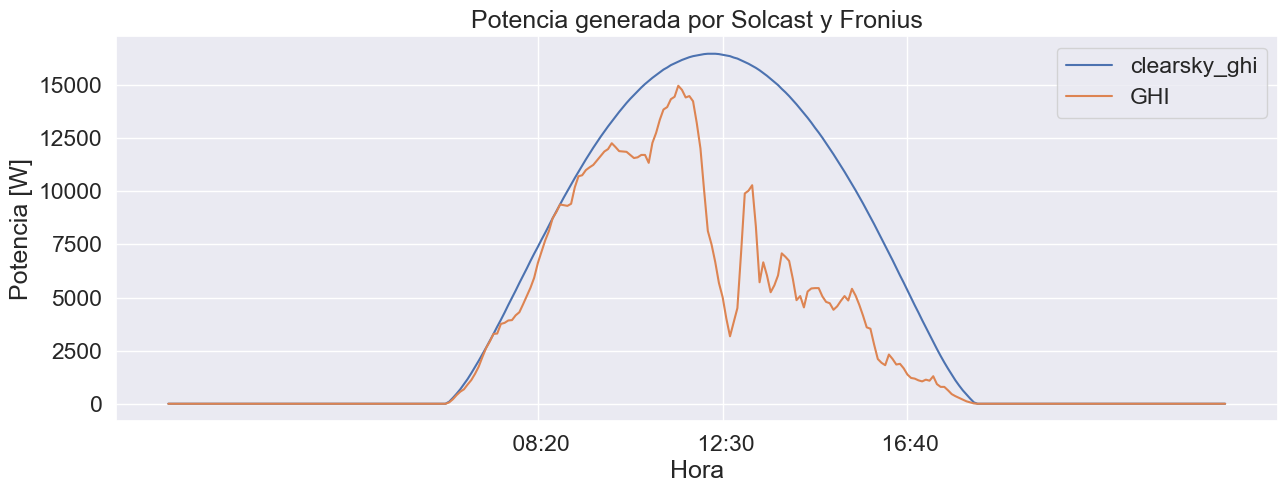

In [115]:
# graficar df[clearsky_ghi] y df['Potencia']
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], P_clearsky_ghi, label='clearsky_ghi')
plt.plot(df['Time'], P_ghi, label='GHI')
# plt.plot(df['Time'], df['Potencia'], label='Fronius')
plt.title('Potencia generada por Solcast y Fronius')
plt.xlabel('Hora')
plt.ylabel('Potencia [W]')
plt.legend()
plt.xticks([100, 150, 200])
plt.show()



## Análisis de las DB

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


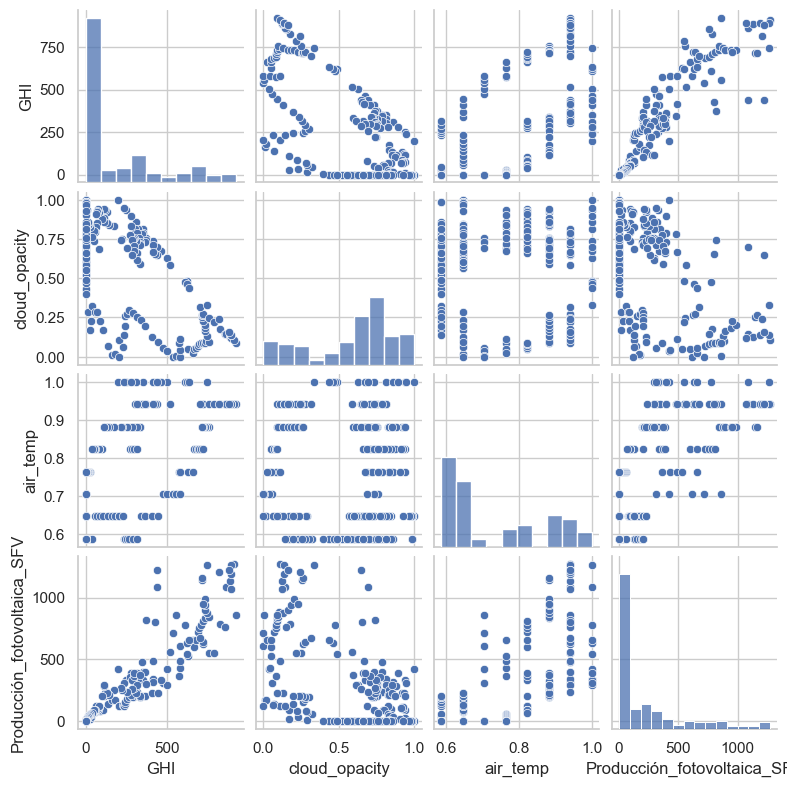

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set
sns.set(style="whitegrid", context="notebook")
cols = ['GHI', 'cloud_opacity', 'air_temp', 'Producción_fotovoltaica_SFV']
sns.pairplot(df[cols], size=2)
plt.show()


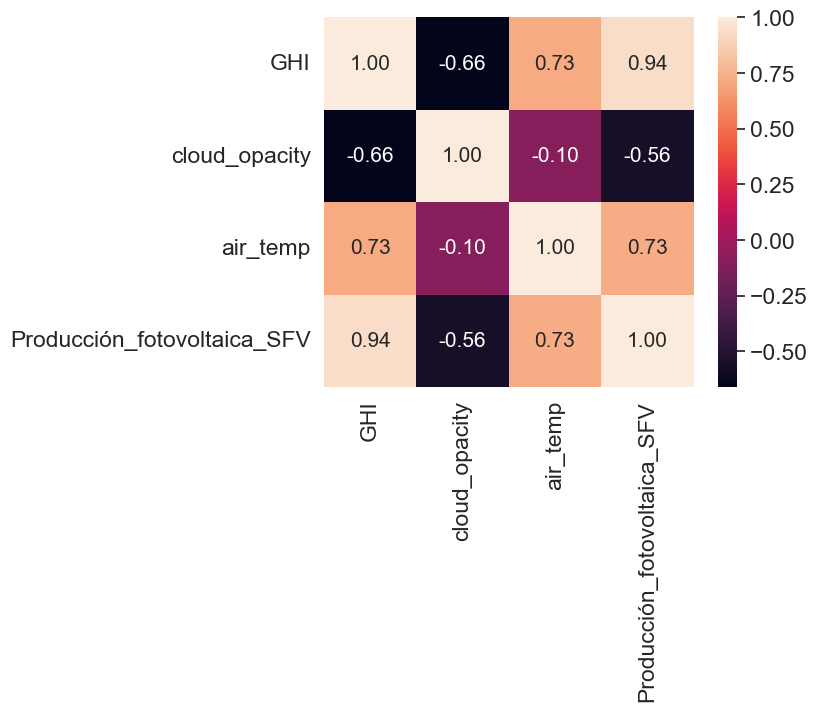

In [117]:
#heatmap
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

## Análisis por error

In [118]:
from scipy.optimize import minimize

# Define la función de error (en este caso, el error cuadrático medio)
def error_func(params):
    alpha, beta = params
    #Parametros SFV
    efficiency = 0.2094  # Eficiencia del panel solar
    catidad_pv= 30
    area =2.274*1.134
    predicted_power = df['GHI'] * efficiency * area * catidad_pv * (1 - beta * df['cloud_opacity']) * (1 - alpha * df['air_temp'])
    error = ((predicted_power - df['Potencia']) ** 2).mean()  # Error cuadrático medio
    return error

# Suponiendo que tengas valores iniciales para alpha y beta
initial_guess = [0.1, 0.1]  # Por ejemplo

# Realiza la optimización para minimizar el error
result = minimize(error_func, initial_guess, method='Nelder-Mead')

# Los valores óptimos se encuentran en result.x
optimal_alpha, optimal_beta = result.x
print("Los valores óptimos son:")
print("Alpha:", optimal_alpha)
print("Beta:", optimal_beta)


Los valores óptimos son:
Alpha: 0.20248362266973507
Beta: -0.11287450624580009


## 🏐

In [119]:
from scipy.optimize import minimize

# Función para minimizar la diferencia entre las energías calculadas
def objective_function(params):
    alpha, beta = params
    energia_solcast = df['GHI'] * efficiency * area * catidad_pv * (1 - beta * df['cloud_opacity']) * (1 - alpha * df['air_temp']) * (5 / 60)
    diff = energia_solcast.sum() - energia_fronius
    return abs(diff)

# Valores iniciales de alpha y beta
initial_guess = [0.1, 0.1]

# Minimización de la función objetivo
result = minimize(objective_function, initial_guess, bounds=((0, 1), (-1, 0)))
alpha_optimal, beta_optimal = result.x

print("Alpha óptimo:", alpha_optimal)
print("Beta óptimo:", beta_optimal)


Alpha óptimo: 0.19770557217384027
Beta óptimo: -1.0234405153332126e-09
